In [1]:
# If you are using different method to initialize spark session, this block might be different.
import findspark
findspark.init()

import pyspark
from pyspark import SparkContext, SparkConf
from pyspark.sql import SQLContext
from pyspark.sql.functions import *

sc = pyspark.SparkContext(appName="proj")
sqlContext = SQLContext(sc)

In [2]:
class GeolifeTrajectoriesData():
    def __init__(self, SparkContext = sc, path = 'Geolife Trajectories 1.3/Data/*/*'):
        self.attributes = ['Latitude', 'Longitude', 'Altitude in feet', 'Date', 'Time']
        self.data = SparkContext.wholeTextFiles(path)\
                                .flatMap(lambda x:x[1].split('\r\n')[6:])\
                                .map(lambda x:x.split(','))\
                                .filter(lambda x:len(x) == 7)

    def __repr__(self):
        df = self.getDataFrame()
        df.printSchema()
        df.show()
        return str(df.count()) + ' Data points'
                    
    def getRDD(self, cache = False, sample = 0):
        rdd = self.data.map(lambda x:[float(x[0]), float(x[1]), float(x[3]), x[5], x[6]])
        if cache:
            rdd = rdd.cache()
        return rdd
        
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df
        
    def getAttributes(self):
        return self.attributes

In [50]:
data = GeolifeTrajectoriesData(sc, 'Geolife Trajectories 1.3/Data/130/*')
print(data)

root
 |-- Latitude: double (nullable = true)
 |-- Longitude: double (nullable = true)
 |-- Altitude in feet: double (nullable = true)
 |-- Date: string (nullable = true)
 |-- Time: string (nullable = true)

+---------+----------+----------------+----------+--------+
| Latitude| Longitude|Altitude in feet|      Date|    Time|
+---------+----------+----------------+----------+--------+
|39.974561| 116.29647|162.158549868766|2009-08-30|14:41:12|
|39.974464|116.296562|158.387893700787|2009-08-30|14:41:14|
|39.974671|116.296879| 164.82845144357|2009-08-30|14:41:19|
|39.974638|116.296925|161.119796587926|2009-08-30|14:41:21|
|39.974638|116.296987|160.238487532808|2009-08-30|14:41:22|
|39.974578|116.297042|167.166154855643|2009-08-30|14:41:24|
|39.974497|116.297141|167.591679790026|2009-08-30|14:41:25|
|39.974425| 116.29721|165.564730971129|2009-08-30|14:41:26|
|39.974355|116.297206|162.712719816273|2009-08-30|14:41:29|
|39.974336|116.297172|150.754957349081|2009-08-30|14:41:31|
| 39.97425|11

In [51]:
position_subset = data.getRDD().map(lambda x:[x[0], x[1]]).collect()
position_subset_x = [ps[1] for ps in position_subset]
position_subset_y = [ps[0] for ps in position_subset]

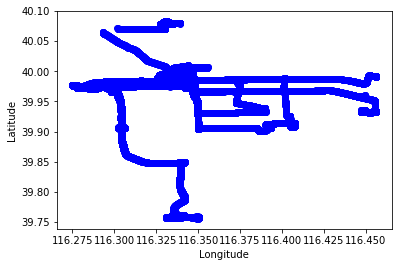

In [52]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.plot(position_subset_x, position_subset_y, 'ob')
plt.xlabel('Longitude')
plt.ylabel('Latitude') 
plt.show()

In [46]:
data.getRDD().map(lambda x: [x[0], x[1]]).take(5)

[[39.9771583333333, 116.329861666667],
 [39.97702, 116.329908333333],
 [39.977205, 116.329673333333],
 [39.97721, 116.329653333333],
 [39.97721, 116.32965]]

In [73]:
class PartitionedData():
    def __init__(self, input_data, SparkContext = sc):
        self.data = input_data.map(lambda x: [x[0],x[1]]).map(lambda x:[x,regionIds(x)])
    
    def getRDD(self, cache = False, sample = 0, region = [0,0]):
        rdd = self.data.map(lambda x: [x[1], x[0]]) if region==[0,0] else self.data.filter(lambda x: region in x[1]).map(lambda x: [x[1], x[0]])
        if cache:
            rdd = rdd.cache()
        return rdd
    
    def getDataFrame(self, cache = False):
        df = self.getRDD().toDF(self.attributes)
        if cache:
            df = df.cache()
        return df
    
    def regionIds(datum):
        regions = []
        root_region = [int(datum[1]/20), int(datum[0]/10)]
        regions.append(root_region)
        is_left = True if (datum[1]<(root_region[0]-1)*20+0.2) else False #left
        is_right = True if (datum[1]>(root_region[0]+1)*20-0.2) else False #right
        is_up = True if (datum[0]<(root_region[1]-1)*20+0.2) else False #up
        is_down = True if (datum[0]>(root_region[1]+1)*20-0.2) else False #down

        if is_left:
            regions.append([(root_region[0]-1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]-1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]-1),root_region[1]+1])
        elif is_right:
            regions.append([(root_region[0]+1),root_region[1]])
            if is_up:
                regions.append([(root_region[0]+1),root_region[1]-1])
            elif is_down:
                regions.append([(root_region[0]+1),root_region[1]+1])
        elif is_up:
            regions.append([(root_region[0]),root_region[1]-1])
        elif is_down:
            regions.append([(root_region[0]),root_region[1]+1])

        return regions
    
    

In [74]:
d = PartitionedData(data.getRDD(), sc)

In [76]:
d.getRDD(region = [5,2]).take(10)

[[[[5, 3], [5, 2]], [39.974561, 116.29647]],
 [[[5, 3], [5, 2]], [39.974464, 116.296562]],
 [[[5, 3], [5, 2]], [39.974671, 116.296879]],
 [[[5, 3], [5, 2]], [39.974638, 116.296925]],
 [[[5, 3], [5, 2]], [39.974638, 116.296987]],
 [[[5, 3], [5, 2]], [39.974578, 116.297042]],
 [[[5, 3], [5, 2]], [39.974497, 116.297141]],
 [[[5, 3], [5, 2]], [39.974425, 116.29721]],
 [[[5, 3], [5, 2]], [39.974355, 116.297206]],
 [[[5, 3], [5, 2]], [39.974336, 116.297172]]]